In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP import Fingerprint, Fingerprint_viz, graph_dict, graph_dataset, null_collate, Graph, Logger, time_to_str


In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  4200
number of successfully processed smiles:  4200


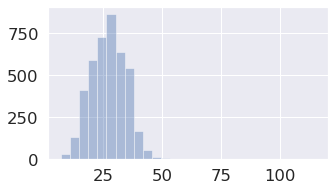

In [4]:
task_name = 'lipophilicity'
tasks = ['exp']

raw_filename = "../data/Lipophilicity.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

epochs = 80
batch_size =50

p_dropout= 0.1
fingerprint_dim = 100

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 3
K = 2
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smiles_list = smiles_tasks_df['smiles'].values
label_list = smiles_tasks_df[tasks[0]].values
graph_dict = graph_dict(smiles_list, label_list, filename)


graph dicts loaded from ../data/Lipophilicity.pkl


In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
train_fold = []
valid_fold = []
for k, (train_idx, valid_idx) in enumerate(kfold.split(smiles_list)):
    train_fold.append(train_idx)
    valid_fold.append(valid_idx)
    
# avoiding the last batch has too few samples by slightly tune the batch_size
while (len(train_fold[0]) % batch_size) / batch_size <0.8:
    batch_size +=1
print("batch size: ", batch_size)

batch size:  51


In [8]:
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

601854
sum_importance torch.Size([1])
preprocess.0.linear.weight torch.Size([100, 39])
preprocess.0.linear.bias torch.Size([100])
preprocess.0.bn.weight torch.Size([100])
preprocess.0.bn.bias torch.Size([100])
propagate.0.encoder.0.linear.weight torch.Size([10000, 10])
propagate.0.encoder.0.linear.bias torch.Size([10000])
propagate.0.encoder.0.bn.weight torch.Size([10000])
propagate.0.encoder.0.bn.bias torch.Size([10000])
propagate.0.align.weight torch.Size([1, 200])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([100, 100])
propagate.0.attend.linear.bias torch.Size([100])
propagate.0.attend.bn.weight torch.Size([100])
propagate.0.attend.bn.bias torch.Size([100])
propagate.0.gru.weight_ih torch.Size([300, 100])
propagate.0.gru.weight_hh torch.Size([300, 100])
propagate.0.gru.bias_ih torch.Size([300])
propagate.0.gru.bias_hh torch.Size([300])
propagate.1.encoder.0.linear.weight torch.Size([10000, 10])
propagate.1.encoder.0.linear.bias torch.Size([1000

In [9]:
def train(smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(train_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        
        loss = loss_function(mol_prediction, label.view(-1,1))     
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

        
def eval(smiles_list):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    eval_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(eval_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction, label.view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, label.view(-1,1), reduction='none')
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.sqrt(np.array(eval_MAE_list).mean()), np.sqrt(np.array(eval_MSE_list).mean())


In [10]:
# log = Logger()
# log.open(f'{prefix_filename}_{start_time}.txt')

# f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
# log.write('epoch | loss | train MSE |  valid MSE |  time \n')
# start = timer()

# best_param ={}
# best_param["train_epoch"] = 0
# best_param["valid_epoch"] = 0
# best_param["train_MSE"] = 9e8
# best_param["valid_MSE"] = 9e8

# fold_index = 3
# for epoch in range(800):
#     losses = train(smiles_list[train_fold[fold_index]])
#     traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
#     valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])

#     timing = time_to_str((timer() - start), 'min')  
#     log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))

#     if train_MSE < best_param["train_MSE"]:
#         best_param["train_epoch"] = epoch
#         best_param["train_MSE"] = train_MSE
#     if valid_MSE < best_param["valid_MSE"]:
#         best_param["valid_epoch"] = epoch
#         best_param["valid_MSE"] = valid_MSE
# #         if valid_MSE < 0.35:
# #              torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
# print(best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"])

In [11]:

log = Logger()
log.open(f'log/{prefix_filename}_{start_time}.txt')

f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
log.write('epoch | loss | train RMSE |  valid RMSE |  time \n')
start = timer()

log2 = Logger()
log2.open(f'{prefix_filename}_best_{start_time}.txt')
f2 = '{:^5} | {:^5} | {:^7.4f} | {:^7.4f} \n'

for fold_index in range(5):
    
    model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
    
    best_param ={}
    best_param["train_epoch"] = 0
    best_param["valid_epoch"] = 0
    best_param["train_RMSE"] = 800
    best_param["valid_RMSE"] = 800
    for epoch in range(800):
        losses = train(smiles_list[train_fold[fold_index]])
        traine_MAE, train_RMSE = eval(smiles_list[train_fold[fold_index]])
        valid_MAE, valid_RMSE = eval(smiles_list[valid_fold[fold_index]])
        
        timing = time_to_str((timer() - start), 'min')  
        log.write(f.format(epoch, losses, train_RMSE, valid_RMSE, timing))
        
        if train_RMSE < best_param["train_RMSE"]:
            best_param["train_epoch"] = epoch
            best_param["train_RMSE"] = train_RMSE
        if valid_RMSE < best_param["valid_RMSE"]:
            best_param["valid_epoch"] = epoch
            best_param["valid_RMSE"] = valid_RMSE
#             if valid_RMSE < 0.35:
#                  torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
        if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
            break

    log2.write('fold | epoch | train RMSE | valid RMSE \n')
    log2.write(f2.format(fold_index, best_param["valid_epoch"],best_param["train_RMSE"],best_param["valid_RMSE"]))
    
    

epoch | loss | train RMSE |  valid RMSE |  time 
  0   | 1.7159  | 1.1824  | 1.0916  |  0 hr 00 min 
  1   | 1.0324  | 1.0338  | 0.9955  |  0 hr 00 min 
  2   | 0.8129  | 0.8763  | 0.8495  |  0 hr 00 min 
  3   | 0.6796  | 0.9418  | 0.9865  |  0 hr 00 min 
  4   | 0.6392  | 0.7237  | 0.7684  |  0 hr 00 min 
  5   | 0.5721  | 0.7080  | 0.7451  |  0 hr 00 min 
  6   | 0.5452  | 0.6552  | 0.7169  |  0 hr 00 min 
  7   | 0.5023  | 0.6250  | 0.7444  |  0 hr 00 min 
  8   | 0.4719  | 0.6409  | 0.7504  |  0 hr 00 min 
  9   | 0.4531  | 0.6020  | 0.7106  |  0 hr 00 min 
 10   | 0.4244  | 0.5699  | 0.7037  |  0 hr 01 min 
 11   | 0.4014  | 0.5720  | 0.6889  |  0 hr 01 min 
 12   | 0.3992  | 0.5530  | 0.6745  |  0 hr 01 min 
 13   | 0.3676  | 0.5909  | 0.6915  |  0 hr 01 min 
 14   | 0.3528  | 0.5300  | 0.6829  |  0 hr 01 min 
 15   | 0.3404  | 0.5277  | 0.7063  |  0 hr 01 min 
 16   | 0.3111  | 0.4913  | 0.6708  |  0 hr 01 min 
 17   | 0.3117  | 0.4731  | 0.6669  |  0 hr 01 min 
 18   | 0.2868 

 56   | 0.0998  | 0.2131  | 0.6355  |  0 hr 13 min 
 57   | 0.0962  | 0.2021  | 0.6357  |  0 hr 13 min 
 58   | 0.0897  | 0.2115  | 0.6420  |  0 hr 14 min 
 59   | 0.0916  | 0.1954  | 0.6342  |  0 hr 14 min 
 60   | 0.0903  | 0.1999  | 0.6394  |  0 hr 14 min 
 61   | 0.0939  | 0.2048  | 0.6363  |  0 hr 14 min 
 62   | 0.0891  | 0.2084  | 0.6355  |  0 hr 14 min 
 63   | 0.0950  | 0.1993  | 0.6330  |  0 hr 14 min 
 64   | 0.0875  | 0.2090  | 0.6305  |  0 hr 14 min 
 65   | 0.0872  | 0.2172  | 0.6345  |  0 hr 14 min 
 66   | 0.0909  | 0.1987  | 0.6314  |  0 hr 14 min 
 67   | 0.0924  | 0.1901  | 0.6248  |  0 hr 14 min 
 68   | 0.0932  | 0.2002  | 0.6333  |  0 hr 14 min 
 69   | 0.0886  | 0.2031  | 0.6459  |  0 hr 14 min 
 70   | 0.0799  | 0.1890  | 0.6264  |  0 hr 15 min 
 71   | 0.0743  | 0.1862  | 0.6282  |  0 hr 15 min 
 72   | 0.0768  | 0.1873  | 0.6303  |  0 hr 15 min 
 73   | 0.0999  | 0.1874  | 0.6353  |  0 hr 15 min 
 74   | 0.0938  | 0.2190  | 0.6472  |  0 hr 15 min 
 75   | 0.08

 90   | 0.0770  | 0.1857  | 0.6095  |  0 hr 27 min 
 91   | 0.0693  | 0.1719  | 0.6006  |  0 hr 28 min 
 92   | 0.0796  | 0.1746  | 0.6028  |  0 hr 28 min 
 93   | 0.0723  | 0.1666  | 0.5991  |  0 hr 28 min 
 94   | 0.0757  | 0.1687  | 0.5965  |  0 hr 28 min 
 95   | 0.0755  | 0.1659  | 0.6084  |  0 hr 28 min 
 96   | 0.0624  | 0.1564  | 0.6045  |  0 hr 28 min 
 97   | 0.0753  | 0.1816  | 0.6206  |  0 hr 28 min 
 98   | 0.0673  | 0.2004  | 0.6159  |  0 hr 28 min 
 99   | 0.0756  | 0.1677  | 0.6078  |  0 hr 28 min 
 100  | 0.0683  | 0.1742  | 0.6134  |  0 hr 28 min 
 101  | 0.0699  | 0.2283  | 0.6191  |  0 hr 29 min 
 102  | 0.0686  | 0.1604  | 0.6040  |  0 hr 29 min 
 103  | 0.0637  | 0.1606  | 0.5977  |  0 hr 29 min 
 104  | 0.0751  | 0.2361  | 0.6130  |  0 hr 29 min 
 105  | 0.0724  | 0.1501  | 0.6016  |  0 hr 29 min 
 106  | 0.0824  | 0.1739  | 0.5971  |  0 hr 29 min 
 107  | 0.0636  | 0.3050  | 0.6480  |  0 hr 29 min 
 108  | 0.0666  | 0.1592  | 0.6003  |  0 hr 29 min 
 109  | 0.06

 111  | 0.0596  | 0.1702  | 0.6517  |  0 hr 46 min 
 112  | 0.0683  | 0.2011  | 0.6523  |  0 hr 47 min 
 113  | 0.0655  | 0.1736  | 0.6508  |  0 hr 47 min 
 114  | 0.0740  | 0.1937  | 0.6546  |  0 hr 47 min 
 115  | 0.0711  | 0.1968  | 0.6580  |  0 hr 47 min 
 116  | 0.0587  | 0.2134  | 0.6637  |  0 hr 47 min 
 117  | 0.0645  | 0.1557  | 0.6408  |  0 hr 47 min 
 118  | 0.0691  | 0.1556  | 0.6376  |  0 hr 48 min 
 119  | 0.0628  | 0.1660  | 0.6404  |  0 hr 48 min 
fold | epoch | train RMSE | valid RMSE 
  3   |  96   | 0.1475  | 0.6325  
  0   | 1.6110  | 1.3965  | 1.4880  |  0 hr 48 min 
  1   | 0.7799  | 0.9757  | 1.0576  |  0 hr 48 min 
  2   | 0.7005  | 0.7806  | 0.8694  |  0 hr 48 min 
  3   | 0.5538  | 0.6950  | 0.7882  |  0 hr 48 min 
  4   | 0.4953  | 0.6831  | 0.7772  |  0 hr 49 min 
  5   | 0.4681  | 0.5827  | 0.7308  |  0 hr 49 min 
  6   | 0.4384  | 0.5702  | 0.7132  |  0 hr 49 min 
  7   | 0.4062  | 0.5842  | 0.7519  |  0 hr 49 min 
  8   | 0.3869  | 0.5873  | 0.7752  |  0 

In [12]:
# # evaluate model
# best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
# test_MAE, test_MSE = eval(model, test_df)
# print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

In [13]:
# for e in range(20):
#     losses = train(smiles_list[valid_fold[fold_index]])
#     print(losses)